In [1]:
# By Olek Yardas [oyardas2]
# and Dreycen Foiles [dfoiles2]

# Work distribution:
# We both contributed equally to analysis, coding, and results.

# Part I: Implement Lasso

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed
np.random.seed(7568)

## Load Data

In [3]:
myData = pd.read_csv("Coding2_Data.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [4]:
X.shape, len(y)

((506, 13), 506)

## CD for Lasso

In [5]:
def bstar(r, z, lam):
    znorm = np.linalg.norm(z)**2
    a = np.dot(r, z) / znorm
    l = 2 * len(r) * lam / znorm
    if a > l/2:
        bstar = a - (l/2)
    elif abs(a) <= l/2:
        bstar = 0
    elif a < -l/2:
        bstar = a + (l/2)
    else:
        raise ValueError('ya done fucked up')
    return bstar

def one_var_lasso(r, z, lam):
    #################
    # Your CODE
    #################
    return bstar(r, z, lam)

In [6]:
def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 
    ##############################
    centers = np.mean(X,axis=0)
    scales = np.std(X,axis=0)
    newX = (X - centers)/scales
    

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y

    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r.flatten(), X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[0,:]
    ##############################
    B[0,:] = np.mean(y) - np.sum((centers * B[1:,:].T / scales).T, axis=0) 
    
        
    B[1:,:] = (B[1:,:].T / scales).T 
    #B[1:,:] = (B[1:,:].T + centers).T
    
    
    return(B)


In [7]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.30999458351285347, 0.49974219884805476)

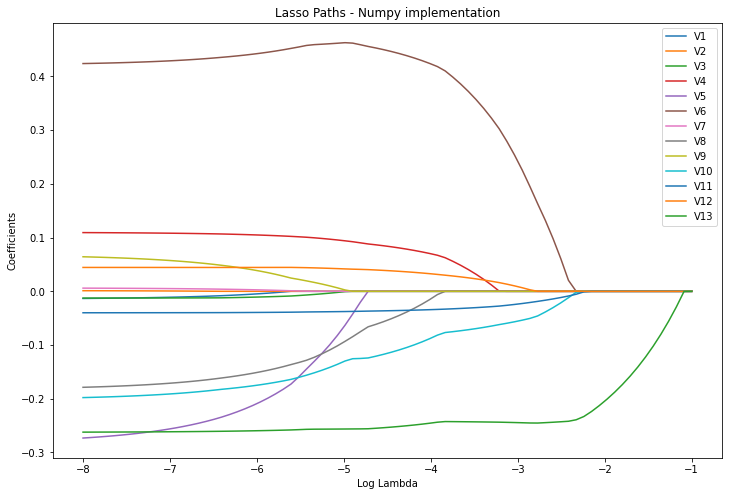

In [8]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

In [ ]:
lasso = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 1)
pred = cvglmnetPredict(lasso, s = lasso['lambda_min'], newx=X[test_ind, :].copy())
lmin = np.mean((Y[test_ind] - pred)**2)

In [9]:
lasso_coef = pd.read_csv("Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [10]:
abs(myout - lasso_coef).max()

0.004645317415906014

Our function works! Error is less than 0.005 and the plot matches the example one.

# Part II: Simulation Study

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import glmnet_python
from glmnet import glmnet
from cvglmnet import cvglmnet
from cvglmnetPredict import cvglmnetPredict
from cvglmnetPlot import cvglmnetPlot
from cvglmnetCoef import cvglmnetCoef

### Create the training and test datasets

First, define our cases

In [20]:
def full(X, Y, train_ind, test_ind):
    # Full model
    full = LinearRegression().fit(X[train_ind, :], Y[train_ind])
    return np.mean((full.predict(X[test_ind, :]) - Y[test_ind])**2)

In [21]:
def ridge(X, Y, train_ind, test_ind):
    ridge_seq = np.exp(np.linspace(-2, -10, num=100))
    ridge_out = cvglmnet(x = X.copy(), y = Y.copy(), alpha = 0, lambdau = ridge_seq)
    ridge = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 0, lambdau = ridge_seq)
    pred = cvglmnetPredict(ridge, s = ridge['lambda_min'], newx=X[test_ind, :].copy())
    lmin = np.mean((Y[test_ind] - pred)**2)
    pred = cvglmnetPredict(ridge, s = ridge['lambda_1se'], newx=X[test_ind, :].copy())
    l_1se = np.mean((Y[test_ind] - pred)**2)
    return (lmin, l_1se)

In [22]:
# Lasso
def lasso(X, Y, train_ind, test_ind):
    lasso = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 1)
    pred = cvglmnetPredict(lasso, s = lasso['lambda_min'], newx=X[test_ind, :].copy())
    lmin = np.mean((Y[test_ind] - pred)**2)
    pred = cvglmnetPredict(lasso, s = lasso['lambda_1se'], newx=X[test_ind, :].copy())
    l_1se = np.mean((Y[test_ind] - pred)**2)
    lasso_coef = cvglmnetCoef(lasso, s = 'lambda_1se')
    var_sel = np.nonzero(lasso_coef[1:])[0]
    tmp_train = X[train_ind[:,None], var_sel[None, :]]
    tmp_test = X[test_ind[:,None], var_sel[None, :]]
    refit_model = LinearRegression().fit(tmp_train, Y[train_ind])
    pred = refit_model.predict(tmp_test)
    refit = np.mean((pred - Y[test_ind])**2)
    return (lmin, l_1se, refit)

In [23]:
# PCR

class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)
        
        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]
            
            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])
            
            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = LinearRegression().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)


In [24]:
def pcr(X, Y, train_ind, test_ind):
    pcr_obj = PCR()
    pcr_obj.fit(X[train_ind, :], Y[train_ind])
    preds = pcr_obj.predict(X[test_ind, :])
    return np.mean((Y[test_ind] - preds)**2)
    

Then, we do the 50 cases

### Case I

In [25]:
myData = pd.read_csv('Coding2_Data2.csv')
var_names = myData.columns
Y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

full_res = []
ridge_lmin_res = []
ridge_l1se_res = []
lasso_lmin_res = []
lasso_l1se_res = []
refit_res = []
pcr_res = []

n = len(Y)
indices = np.arange(0, n)
for i in range(0,50):
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*n))]
    train_ind = indices[len(test_ind):]
    full_res.append(full(X, Y, train_ind, test_ind))
    ridge_res = ridge(X, Y, train_ind, test_ind)
    ridge_lmin_res.append(ridge_res[0])
    ridge_l1se_res.append(ridge_res[1])
    lasso_res = lasso(X, Y, train_ind, test_ind)
    lasso_lmin_res.append(lasso_res[0])
    lasso_l1se_res.append(lasso_res[1])
    refit_res.append(lasso_res[2])
    pcr_res.append(pcr(X, Y, train_ind, test_ind))
    




(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

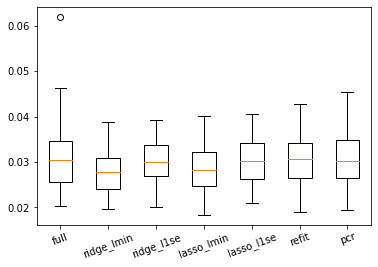

In [26]:
res_i = [full_res,
         ridge_lmin_res,
         ridge_l1se_res,
         lasso_lmin_res,
         lasso_l1se_res,
         refit_res,
         pcr_res]
plt.boxplot(res_i, labels=['full',
                           'ridge_lmin',
                           'ridge_l1se',
                           'lasso_lmin',
                           'lasso_l1se',
                           'refit',
                           'pcr'])
plt.xticks(rotation=20)

Based on our simulation results, we make the following conclusions:

1. Ridge regression with lambda.min perfoms the best as seen in the figure. Note that Lasso with lambda.min is a very close second. 
2. Ridge regresssion with lambda.1se performs the worst
3. For ridge regression, lambda.min produces better MSPE
4. For Lasso, lambda.min produces better MSPE
5. The Refit method performs about the sam as Lasso.1se, although it has less variance in the 1st quartile.
6. It is worth doing variable selection, as we reduce variance and improve the computational performance of out model without a significant difference in prediction accuracy.

### Case II

In [27]:
myData = pd.read_csv('Coding2_Data3.csv')
var_names = myData.columns
Y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

ridge_lmin_res_ii = []
ridge_l1se_res_ii = []
lasso_lmin_res_ii = []
lasso_l1se_res_ii = []
refit_res_ii = []
pcr_res_ii = []

n = len(Y)
indices = np.arange(0, n)
for i in range(0,50):
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*n))]
    train_ind = indices[len(test_ind):]
    ridge_res = ridge(X, Y, train_ind, test_ind)
    ridge_lmin_res_ii.append(ridge_res[0])
    ridge_l1se_res_ii.append(ridge_res[1])
    lasso_res = lasso(X, Y, train_ind, test_ind)
    lasso_lmin_res_ii.append(lasso_res[0])
    lasso_l1se_res_ii.append(lasso_res[1])
    refit_res_ii.append(lasso_res[2])
    pcr_res_ii.append(pcr(X, Y, train_ind, test_ind))
    




(array([1, 2, 3, 4, 5, 6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

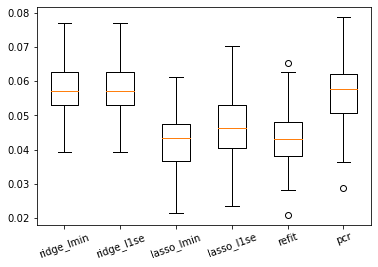

In [28]:
res_ii = [ridge_lmin_res_ii,
         ridge_l1se_res_ii,
         lasso_lmin_res_ii,
         lasso_l1se_res_ii,
         refit_res_ii,
         pcr_res_ii]
plt.boxplot(res_ii, labels=['ridge_lmin',
                           'ridge_l1se',
                           'lasso_lmin',
                           'lasso_l1se',
                           'refit',
                           'pcr'])
plt.xticks(rotation=20)

Based on our simulation results, we make the following conclusions:

1. Lasso with lambda.min perfoms the best as seen in the figure.
2. PCR performs the worst
3. In case 1, all methods perform better. This is due to the lack of noisy data. The additon of the noise data will increase the variance of the fit produced by the methods, spreading out the test error.
4. We see that the Smallest MSPE is bigger in case 2 than it is in case 1. This is most likely due to the extra noise in the dataset creating inaccuary (variance) in the fit.